# Degradation and soiling example


This jupyter notebook is intended to the RdTools trend analysis workflow using the functional API.  In addition, the notebook demonstrates the effects of changes in the workflow. For a consistent experience, we recommend installing the specific versions of packages used to develop this notebook. This can be achieved in your environment by running `pip install -r requirements.txt` followed by `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.) These environments and examples are tested with Python 3.12.

The calculations consist of several steps illustrated here:
<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data to reduce error</li>
  <li><b>Aggregate data</b></li>
  <li><b>Post-aggregation filter</b></li>  
  <li> <b>Analyze</b> aggregated data to estimate the degradation rate</li>
  <li> <b>Analyze</b> aggregated data to estimate the soiling loss</li>
</ol>

Earlier versions of this notebook (RdTools<3.0) included a clear sky workflow in order to check the results for bias from sensor drift. With the wide availability of satellite data, we now recommend repeating the analysis with satellite data to double check the sensor-based result. This is illustrated using the object-oriented API in `TrendAnalysis_example_NSRDB.ipynb`

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  This notebook automatically downloads and locally caches the dataset used in this example. The data can also be found on the DuraMAT Datahub (https://datahub.duramat.org/dataset/pvdaq-time-series-with-soiling-signal).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## 0: Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation. The first step of the `rdtools` workflow is normalization, which requires a time series of energy yield, a time series of cell temperature, and a time series of irradiance, along with some metadata (see Step 1: Normalize)

The following section loads the data, adjusts units where needed, and renames the critical columns. The ambient temperature sensor data source is converted into estimated cell temperature.  This dataset already has plane-of-array irradiance data, so no transposition is necessary.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

<b>The steps of this section may change depending on your data source or the system being considered.</b>  Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

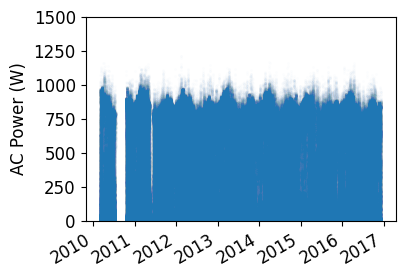

In [4]:
# Import the example data
file_url = ('https://datahub.duramat.org/dataset/'
            'a49bb656-7b36-437a-8089-1870a40c2a7d/'
            'resource/d2c3fcf4-4f5f-47ad-8743-fc29'
            'f1356835/download/pvdaq_system_4_2010'
            '-2016_subset_soil_signal.csv')
cache_file = 'PVDAQ_system_4_2010-2016_subset_soilsignal.pickle'

try:
    df = pd.read_pickle(cache_file)
except FileNotFoundError:
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)
    df.to_pickle(cache_file)

df = df.rename(columns = {
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "power_dc_rated": 1000.0,
        "temp_model_params":
        pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']}

df.index = df.index.tz_localize(meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])

# Then set the frequency of the dataframe.
# It is recommended not to up- or downsample at this step
# but rather to use interpolate to regularize the time series
# to its dominant or underlying frequency. Interpolate is not
# generally recommended for downsampling in this application.
df = rdtools.interpolate(df, freq)

# Calculate cell temperature
df['Tcell'] = pvlib.temperature.sapm_cell(df.poa, df.Tamb,
                                          df.wind_speed, **meta['temp_model_params'])

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.ac_power, 'o', alpha=0.01)
ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)')
plt.show()

This example dataset includes a synthetic soiling signal that can be applied onto the PV power data to illustrate the soiling loss and detection capabilities of RdTools.  AC Power is multiplied by soiling to create the synthetic 'power' channel

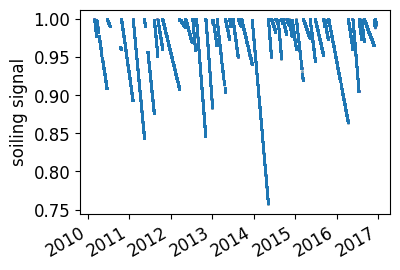

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.soiling, 'o', alpha=0.01)
#ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('soiling signal')
plt.show()

df['power'] = df['ac_power'] * df['soiling']

## 1: Normalize

Data normalization is achieved with `rdtools.normalize_with_expected_power()`. This function can be used to normalize to any modeled or expected power. Note that realized PV output can be given as energy, rather than power, by using an optional key word argument. 

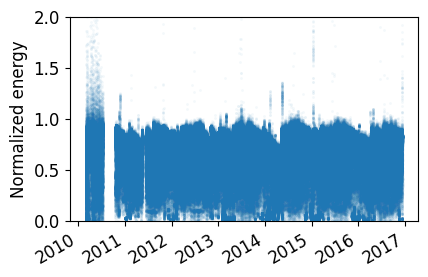

In [6]:
# Calculate the expected power with a simple PVWatts DC model
modeled_power = pvlib.pvsystem.pvwatts_dc(df['poa'], df['Tcell'], meta['power_dc_rated'],
                                          meta['gamma_pdc'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_expected_power(df['power'],
                                                               modeled_power,
                                                               df['poa'])

df['normalized'] = normalized
df['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')
plt.show()

## 2: Filter

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.

It can also be useful to remove outages and outliers. Sometimes outages appear as low but non-zero yield. Automatic functions for outage detection are not yet included in `rdtools`.  However, this example does filter out data points where the normalized energy is less than 1%.  System-specific filters should be implemented by the analyst if needed.

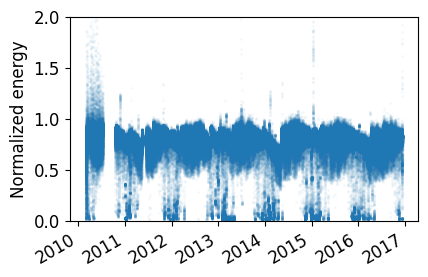

In [7]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
normalized_mask = rdtools.normalized_filter(df['normalized'])
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
# Note: This clipping mask may be disabled when you are sure the system is not
# experiencing clipping due to high DC/AC ratio
clip_mask = rdtools.clip_filter(df['power'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df[normalized_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')
plt.show()

### Filter visualization example: different clipping filters

RdTools provides functions to visualize and tune filters for different applications. In this example, we take a subset of the data, apply an artificial clipping signal, and visualize the results of three different clipping filter methods.

In [8]:
# Apply an artificial clipping signal to a subset of the data
example_subset = df.iloc[0:15000].copy()
example_subset.loc[example_subset['ac_power']>800,'ac_power']=800

# Generate clipping masks with each of the available methods
clip_mask_quantile = rdtools.clip_filter(example_subset['ac_power'], 'quantile')
clip_mask_xgboost = rdtools.clip_filter(example_subset['ac_power'], 'xgboost')
clip_mask_logic = rdtools.clip_filter(example_subset['ac_power'], 'logic')

In [9]:
# NBVAL_IGNORE_OUTPUT
rdtools.tune_filter_plot(example_subset['ac_power'], clip_mask_quantile)

In [10]:
# NBVAL_IGNORE_OUTPUT
rdtools.tune_filter_plot(example_subset['ac_power'], clip_mask_xgboost)

In [11]:
# NBVAL_IGNORE_OUTPUT
rdtools.tune_filter_plot(example_subset['ac_power'], clip_mask_logic)

## 3: Aggregate

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

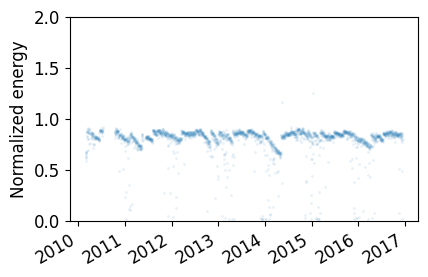

In [12]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation,
                                  frequency = 'D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')
plt.show()

## 4: Post-aggregation filter

RdTools 3 introduces the step of post aggregation filtering to further reduce the influence of anomolous data

In [13]:
two_way_mask = rdtools.two_way_window_filter(daily)
daily_filtered = daily[two_way_mask].resample('D').asfreq()

## 5: Degradation calculation

Data is then analyzed to estimate the degradation rate representing the PV system behavior. The results are visualized and statistics are reported, including the 68.2% confidence interval, and the P95 exceedance value.

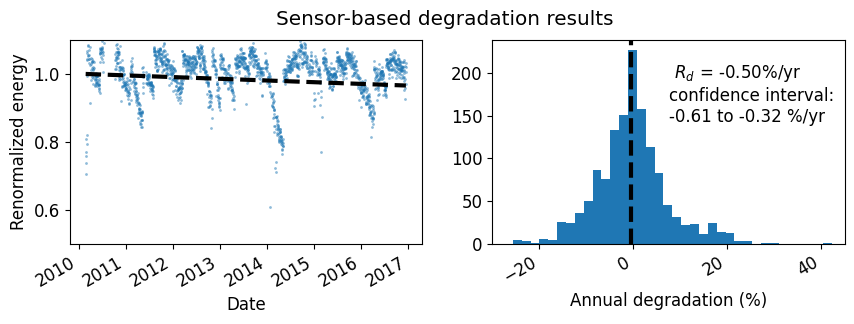

In [14]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily_filtered, confidence_level=68.2)
# Note the default confidence_level of 68.2 is appropriate if you would like to
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results

degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily_filtered,
    summary_title='Sensor-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)
plt.show()

In addition to the confidence interval, the year-on-year method yields an exceedance value (e.g. P95), the degradation rate that was exceeded (slower degradation) with a given probability level. The probability level is set via the `exceedance_prob` keyword in `degradation_year_on_year`.

In [15]:
print(f"The P95 exceedance level is {yoy_info['exceedance_level']:.2f}%/yr" )

The P95 exceedance level is -0.73%/yr


In [16]:
print(np.round(yoy_rd, 3))
print(np.round(yoy_ci, 3))

-0.501
[-0.611 -0.322]


## 5: Soiling calculations  

This section illustrates how the aggregated data can be used to estimate soiling losses using the stochastic rate and recovery (SRR) method.¹ Since our example system doesn't experience much soiling, we apply an artificially generated soiling signal, just for the sake of example.

¹ M. G. Deceglie, L. Micheli and M. Muller, "Quantifying Soiling Loss Directly From PV Yield," IEEE Journal of Photovoltaics, vol. 8, no. 2, pp. 547-551, March 2018. doi: 10.1109/JPHOTOV.2017.2784682

In [17]:
# Calculate the daily insolation, required for the SRR calculation
daily_insolation = filtered['insolation'].resample('D').sum()

# Ensure filtered dataset still has daily frequency
daily_filtered = daily_filtered.resample('D', origin="start_day").asfreq()

# Perform the SRR calculation
from rdtools.soiling import soiling_srr
cl = 68.2
sr, sr_ci, soiling_info = soiling_srr(daily_filtered, daily_insolation,
                                      confidence_level=cl)

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\soiling.py:27: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



In [18]:
print(f'The P50 insolation-weighted soiling ratio is {sr:.3f}')

The P50 insolation-weighted soiling ratio is 0.953


In [19]:
print(f'The {cl}% confidence interval for the insolation-weighted'
      f' soiling ratio is {sr_ci[0]:.3f}–{sr_ci[1]:.3f}')

The 68.2% confidence interval for the insolation-weighted soiling ratio is 0.949–0.956


c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:173: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



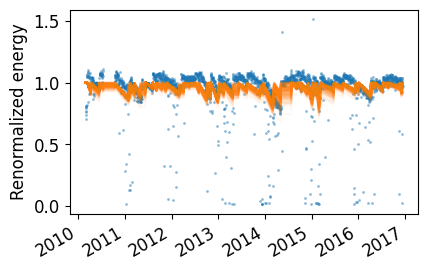

In [20]:
# Plot Monte Carlo realizations of soiling profiles
fig = rdtools.plotting.soiling_monte_carlo_plot(soiling_info, daily, profiles=200)
plt.show()

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:233: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



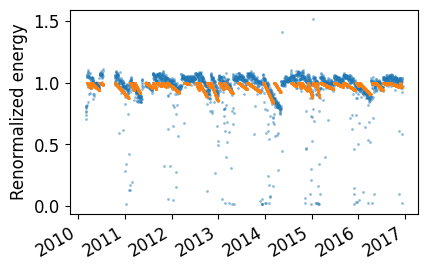

In [21]:
# Plot the slopes for "valid" soiling intervals identified,
# assuming perfect cleaning events
fig = rdtools.plotting.soiling_interval_plot(soiling_info, daily)
plt.show()

In [22]:
# View the first several rows of the soiling interval summary table
soiling_summary = soiling_info['soiling_interval_summary']
soiling_summary.head()

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
0,2010-02-25 00:00:00-07:00,2010-03-03 00:00:00-07:00,0.0,0.0,0.0,0.756022,0.756022,6,False
1,2010-03-04 00:00:00-07:00,2010-03-04 00:00:00-07:00,0.0,0.0,0.0,0.793434,0.793434,0,False
2,2010-03-05 00:00:00-07:00,2010-03-05 00:00:00-07:00,0.0,0.0,0.0,0.819566,0.819566,0,False
3,2010-03-06 00:00:00-07:00,2010-03-07 00:00:00-07:00,0.0,0.0,0.0,1.053380,1.053380,1,False
4,2010-03-08 00:00:00-07:00,2010-03-09 00:00:00-07:00,0.0,0.0,0.0,1.033119,1.033119,1,False


c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:273: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



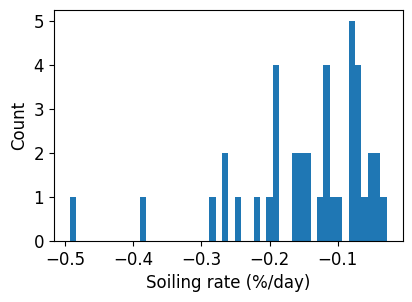

In [23]:
# View a histogram of the valid soiling rates found for the data set
fig = rdtools.plotting.soiling_rate_histogram(soiling_info, bins=50)
plt.show()

These plots show generally good results from the SRR method. In this example, we have slightly overestimated the soiling loss because we used the default behavior of the `method` key word argument in `rdtools.soiling_srr()`, which does not assume that every cleaning is perfect but the example artificial soiling signal did include perfect cleaning. We encourage you to adjust the options of `rdtools.soiling_srr()` for your application.

In [24]:
# Calculate and view a monthly soiling rate summary
from rdtools.soiling import monthly_soiling_rates
monthly_soiling_rates(soiling_info['soiling_interval_summary'],
                      confidence_level=cl)

,month,soiling_rate_median,soiling_rate_low,soiling_rate_high,interval_count
0,1,-0.001184,-0.002336,-0.000875,8
1,2,-0.001488,-0.002649,-0.000902,7
2,3,-0.001307,-0.002049,-0.000620,8
3,4,-0.001114,-0.001764,-0.000443,9
4,5,-0.000683,-0.001163,-0.000407,6
5,6,-0.000806,-0.001124,-0.000525,7
6,7,-0.000804,-0.001550,-0.000480,8
7,8,-0.000859,-0.001907,-0.000442,11
8,9,-0.000730,-0.001841,-0.000441,9
9,10,-0.000779,-0.001611,-0.000480,10


In [25]:
# Calculate and view annual insolation-weighted soiling ratios and their confidence
# intervals based on the Monte Carlo simulation. Note that these losses include the
# assumptions of the cleaning assumptions associated with the method parameter
# of rdtools.soiling_srr(). For anything but 'perfect_clean', each year's soiling
# ratio may be impacted by prior years' soiling profiles. The default behavior of
# rdtools.soiling_srr uses method='half_norm_clean'

from rdtools.soiling import annual_soiling_ratios
annual_soiling_ratios(soiling_info['stochastic_soiling_profiles'],
                      daily_insolation,
                      confidence_level=cl)

,year,soiling_ratio_median,soiling_ratio_low,soiling_ratio_high
0,2010,0.962952,0.954986,0.969507
1,2011,0.957442,0.951042,0.962425
2,2012,0.950871,0.943630,0.956604
3,2013,0.948067,0.938270,0.956403
4,2014,0.934236,0.915437,0.947448
5,2015,0.959483,0.945367,0.967091
6,2016,0.966123,0.961269,0.970014


## CODS

This section gives an introduction to the <b>Combined Degradation and Soiling (CODS)</b> algorithm workflow. For more information about CODS, we refer to [1] and [2].

CODS can be run in two ways - either by setting up an instance of `rdtools.soiling.CODSAnalysis` and running the method `run_bootstrap`, or by directly running `rdtools.soiling.soiling_cods`. Here we will show how to do the first option, as this makes more information available, and since the second option is more straightforward. We start by setting up an instance of `rdtools.soiling.CODSAnalysis`

[1]  Skomedal, Å. and Deceglie, M. G. IEEE J. of Photovoltaics, Sept. 2020
[2]  Skomedal, Å., Deceglie, M. G., Haug, H., and Marstein, E. S., Proceedings of the 37th European Photovoltaic Solar Energy Conference and Exhibition, Sept. 2020



In [26]:
from rdtools.soiling import CODSAnalysis
np.random.seed(0) # improves consistency with other notebook when using a low number of monte carlo reps
CODS = CODSAnalysis(daily_filtered)

We continue to run `run_bootstrap`. The parameter `reps` decides how many repetitions of the bootstrapping procedure should be performed. `reps` needs to be a multiple of 16, and the minimum is 16. However, to give real confidence intervals, we recommend running it with 512 repetitions. In this case we use 16 to to avoid overly much time use. The parameter `verbose` decides whether to output information about the process during the calculation. `bootstrap_seed=42` ensures the same results from the bootstrap sampling each time, used here only for notebook testing.

In [27]:
results_df, degradation, soiling_loss = CODS.run_bootstrap(reps=16, bootstrap_seed=42)

In [28]:
df_out, CODS_results_dict = \
    CODS.iterative_signal_decomposition()
df_out.head()

,soiling_ratio,soiling_rates,cleaning_events,seasonal_component,degradation_trend,total_model,residuals
2010-02-25 00:00:00-07:00,0.632635,0.024614,True,0.999650,1.000000,0.547342,0.963029
2010-02-26 00:00:00-07:00,0.657248,0.024612,False,0.999475,0.999993,0.568532,0.889424
2010-02-27 00:00:00-07:00,0.681860,0.024611,False,0.999299,0.999986,0.589713,0.934689
2010-02-28 00:00:00-07:00,0.706470,0.024609,False,0.999122,0.999978,0.610885,0.945476
2010-03-01 00:00:00-07:00,0.731079,0.024608,False,0.998944,0.999971,0.632047,0.857710


Visualize the results

In [29]:
# The average soiling loss over the period with 95 % confidence intervals
# can be accessed through the soiling_loss attribute of CODS
soiling_loss = CODS.soiling_loss
print(f'Avg. Soiling loss {soiling_loss[0]:.3f} ({soiling_loss[1]:.3f}, {soiling_loss[2]:.3f}) (%)')

# The estimated degradatio rate over the period with 95 % confidence intervals
# can be accessed through the degradation attribute of CODS
degradation = CODS.degradation
print(f'Degradation rate {degradation[0]:.3f} ({degradation[1]:.3f}, {degradation[2]:.3f}) (%)')

Avg. Soiling loss 6.128 (4.569, 6.238) (%)
Degradation rate -0.181 (-0.371, -0.027) (%)


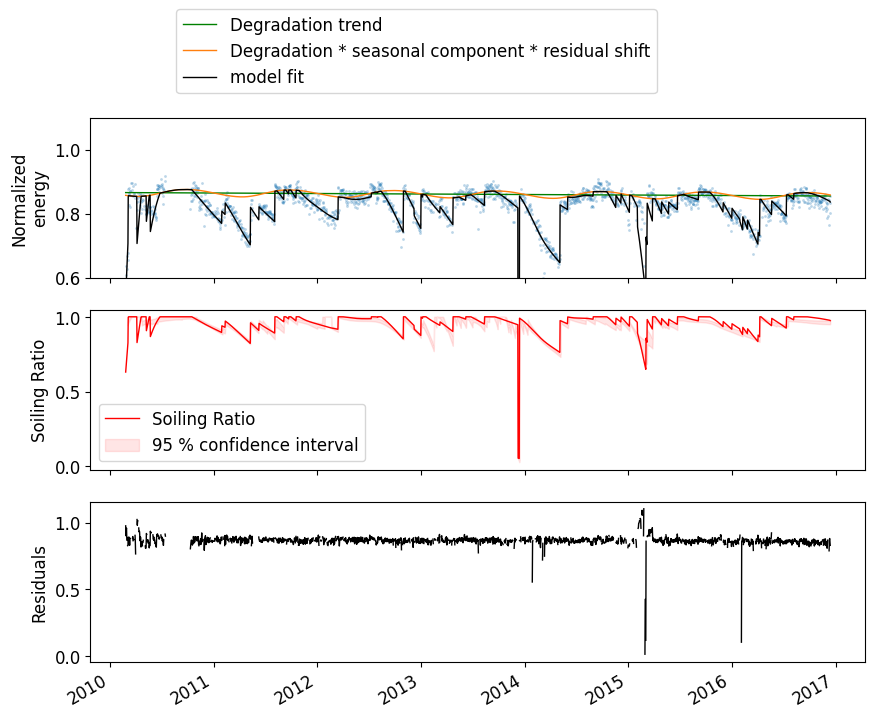

In [30]:
# The dataframe containing the time series of the different component fits
# can be accessed through CODS.result_df
result_df = CODS.result_df

# Let us plot the time series of the results
# First: daily normalized energy along with the total model fit and degradation trend
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.plot(daily_filtered.index, daily_filtered, 'o', alpha = 0.3)
ax1.plot(result_df.index, result_df.degradation_trend * CODS.residual_shift, color='g', linewidth=1,
         label='Degradation trend')
ax1.plot(result_df.index, result_df.degradation_trend * result_df.seasonal_component * CODS.residual_shift,
         color='C1', linewidth=1, label='Degradation * seasonal component * residual shift')
ax1.plot(result_df.index, result_df.total_model, color='k', linewidth=1,
         label='model fit')
ax1.set_ylim(0.6, 1.1)
ax1.set_ylabel('Normalized\nenergy')
ax1.legend(bbox_to_anchor=(0.1, 1.1))

# Second: soiling ratio with 95 % confidence intervals
ax2.plot(result_df.index, result_df.soiling_ratio, color='r', linewidth=1,
         label='Soiling Ratio')
ax2.fill_between(result_df.index, result_df.SR_low, result_df.SR_high,
                 color='r', alpha=.1, label='95 % confidence interval')
ax2.set_ylabel('Soiling Ratio')
ax2.legend()

# Third: The residuals
ax3.plot(result_df.index, result_df.residuals, color='k', linewidth=1)
ax3.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.show()